<a href="https://colab.research.google.com/github/fernandopredes/winepredictor-back/blob/master/datasetwines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


## Carregando o dataset de vinhos

In [18]:
# URL dO dataset
url = "https://raw.githubusercontent.com/fernandopredes/winepredictor-back/master/data/wine_dataset.csv"

# Carregar o dataset diretamente da URL
dataset = pd.read_csv(url)

# Remover a coluna 'od280/od315_of_diluted_wines'
dataset.drop('od280/od315_of_diluted_wines', axis=1, inplace=True)

# Exibindo as primeiras linhas do dataset para confirmar
dataset.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,735.0,0.0


In [19]:
test_size = 0.20
seed = 7

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:,0:12]
y = array[:,12]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=seed, stratify=y)


KNN: 0.647 (0.116)
CART: 0.923 (0.067)
NB: 0.972 (0.047)
SVM: 0.690 (0.073)


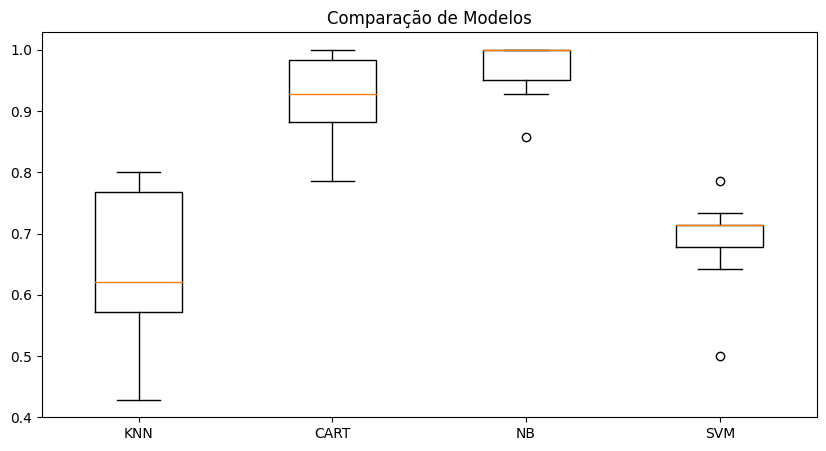

In [20]:
np.random.seed(7)
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

results = []
names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean():.3f} ({cv_results.std():.3f})")

plt.figure(figsize=(10, 5))
plt.boxplot(results)
plt.title('Comparação de Modelos')
plt.xticks([1, 2, 3, 4], names)
plt.show()


KNN-orig: 0.647 (0.116)
CART-orig: 0.909 (0.064)
NB-orig: 0.972 (0.047)
SVM-orig: 0.690 (0.073)
KNN-padr: 0.951 (0.054)
CART-padr: 0.916 (0.062)
NB-padr: 0.972 (0.047)
SVM-padr: 0.979 (0.045)
KNN-norm: 0.965 (0.046)
CART-norm: 0.901 (0.057)
NB-norm: 0.972 (0.047)
SVM-norm: 0.986 (0.028)


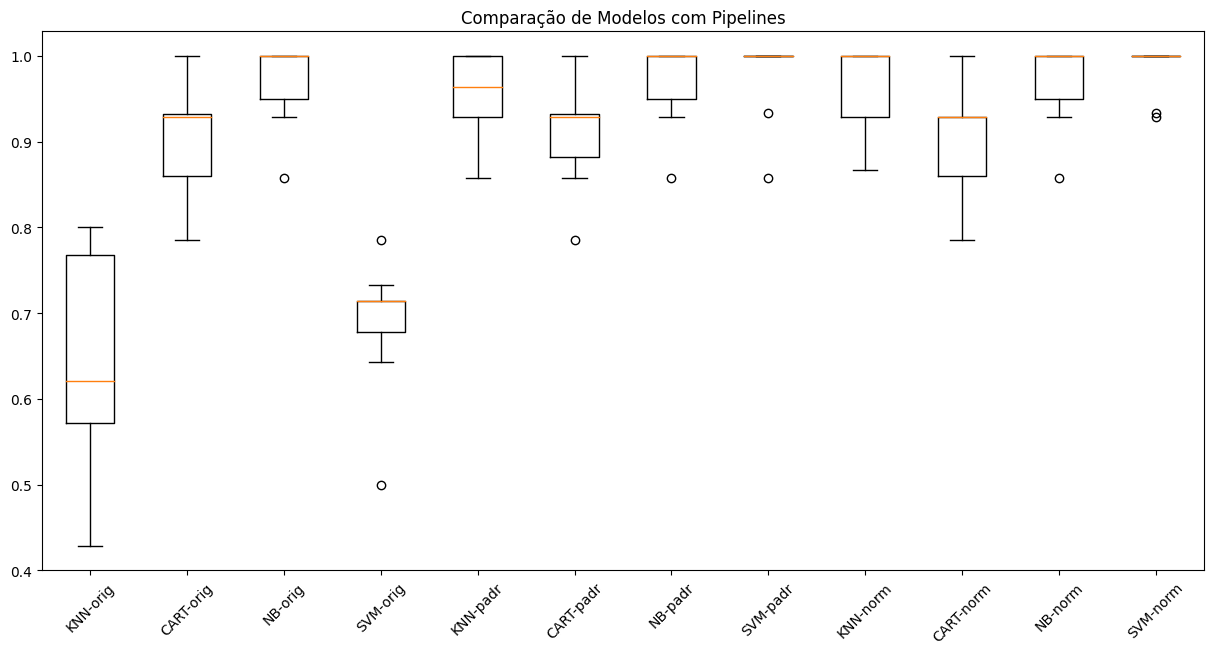

In [21]:
pipelines = []

# Algoritmos
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Pipelines
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

results = []
names = []

for name, pipeline in pipelines:
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean():.3f} ({cv_results.std():.3f})")

plt.figure(figsize=(15, 7))
plt.boxplot(results)
plt.title('Comparação de Modelos com Pipelines')
plt.xticks(list(range(1, len(names) + 1)), names, rotation=45)
plt.show()


## Parâmetros para o KNN / Melhores hiperparâmetros encontrados

In [22]:

param_grid = {
    'n_neighbors': np.arange(1, 31),
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'weights': ['uniform', 'distance']
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, scoring='accuracy', cv=kfold)
grid_result = grid.fit(X_train, y_train)

print(f"Melhor: {grid_result.best_score_:.3f} usando {grid_result.best_params_}")


Melhor: 0.839 usando {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}


## Modelo final / Predição e avaliação

In [23]:

best_knn = KNeighborsClassifier(**grid_result.best_params_)
best_knn.fit(X_train, y_train)


predictions = best_knn.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Acurácia no conjunto de testes: {accuracy:.3f}")


Acurácia no conjunto de testes: 0.778


In [24]:
best_knn.fit(X, y)


KNeighborsClassifier(metric='manhattan', n_neighbors=1)

## Dados fictícios

In [31]:

new_data = [
    [12.00, 1.00, 2.40, 10.0, 100, 2.65, 1, 1, 0.20, 1.38, 3.05, 1100],
    [12.0, 1.50, 2.30, 10.0, 85, 2.20, 2.10, 0.30, 1.10, 3.80, 0.90, 950],
    [13.5, 2.00, 2.50, 12.5, 110, 3.00, 3.10, 0.25, 1.50, 5.00, 1.10, 1150]
]


In [30]:
predictions_new_data = best_knn.predict(new_data)
print(predictions_new_data)


[0. 0. 0.]


## Análise de Resultados do Modelo

O Naive Bayes mostrou alta precisão e consistência, com acurácia média de 0.972 e baixo desvio padrão. CART seguiu com bom desempenho, embora mais variável. SVM e KNN tiveram menor acurácia e maior variabilidade, sugerindo maior sensibilidade às características dos dados.



## Análise de Resultados do Modelo com Pipelines

Impacto das Transformações de Dados:
Transformações como padronização e normalização revelaram a sensibilidade do KNN e SVM à escala dos dados. O KNN teve melhora expressiva de desempenho, e o SVM alcançou a maior acurácia pós-normalização, destacando-se pela confiabilidade.

Análise de Desempenho dos Modelos com Transformação de Dados:
A análise evidencia que modelos baseados em distância, como KNN e SVM, se beneficiam significativamente do pré-processamento adequado, enquanto CART e Naive Bayes são menos afetados pela escala dos dados.


## Conclusões Finais


Os resultados sublinham a importância do pré-processamento no sucesso dos modelos de machine learning. Naive Bayes provou ser robusto, enquanto CART apresentou uma ligeira queda na acurácia com dados normalizados, indicando a necessidade de ajustes específicos.


## Reflexões Finais


Este trabalho destaca a importância da integração das boas práticas de engenharia de software com a análise de dados, onde uma metodologia criteriosa e a otimização de hiperparâmetros são cruciais para desenvolver soluções eficazes de machine learning.